# Fixed beam orientation

**Scott Prahl**

**Mar 2022**

Because of their resonators, most lasers emit stigmatic or simple astigmatic beams.
In this case, the fast and slow axes are fixed and do not change with axial position.
Consequently, fixing the rotation angle when analyzing such experiments is handy.

The way that `laserbeamsize` analyzes the beam is by finding its center, diameters, and rotation ϕ from the image.  Then the region of interest is reduced to a rectangle 3X the diameters and rotated by ϕ.  This ROI is analyzed compared with the previous value until the diameters converge to a constant value.

If the rotation ϕ is specified, the process is exactly the same except the rotation angle never changes.

A couple of examples are given in this notebook.

In [1]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import laserbeamsize as lbs
    
pixel_size_µm = 3.75          # pixel size in microns for the camera
repo = "https://github.com/scottprahl/laserbeamsize/raw/main/docs/"

### A square beam

Let's start with the default parameters for `beam_size`.  The rotated fit that we see is somewhat surprising because our brains automatically recognize the square image and assign axes to it.  However, if you look at the cross-sections, then the fits are quite good.

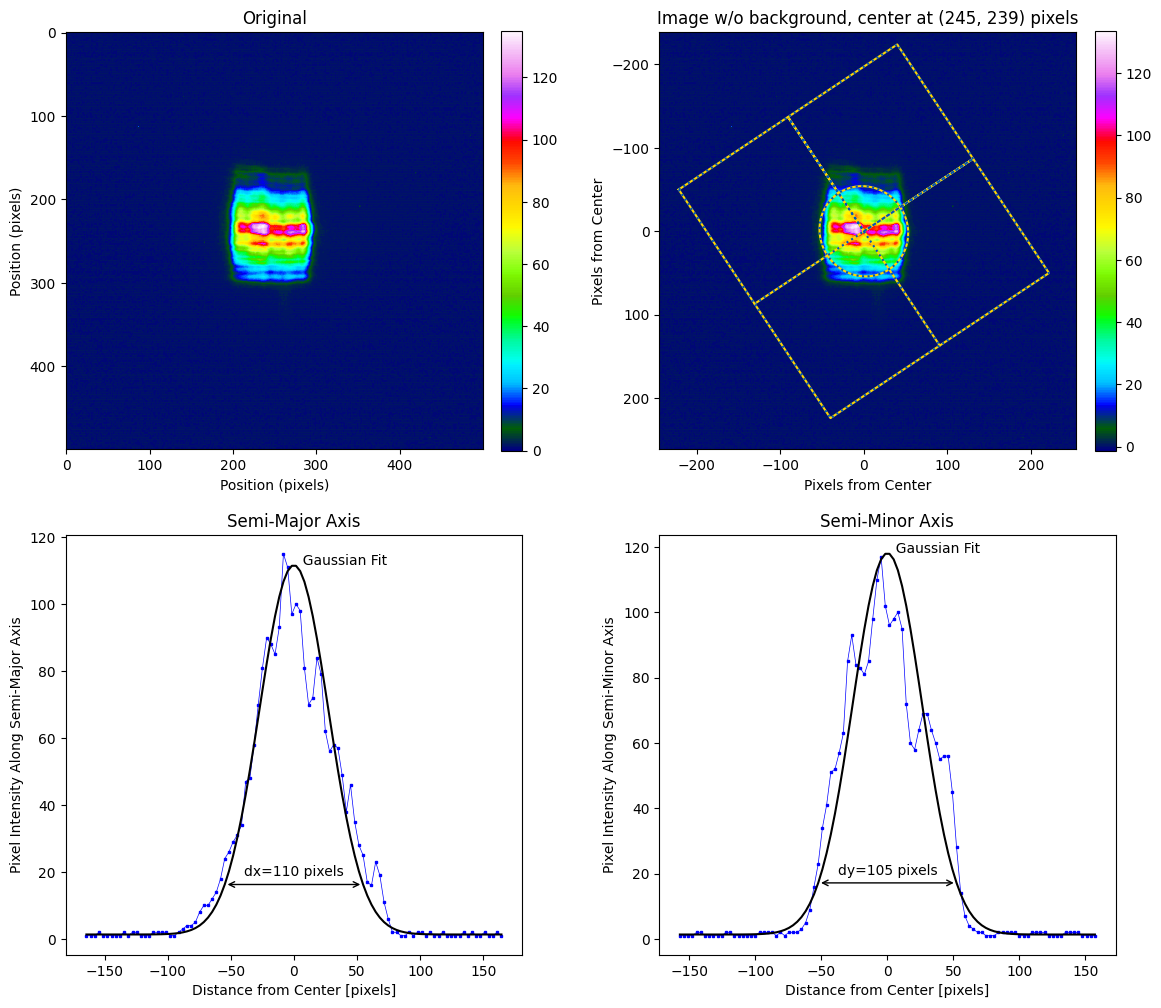

In [2]:
beam_color = iio.imread(repo + "astigmatic_beam.tif")
beam = beam_color[250:750,500:1000,0]

lbs.plot_image_analysis(beam)
plt.show()

What happens when we force the fast axis to be vertical?  In this case, we get an excellent fit to the fast axis but a mediocre one along the slow axis.  

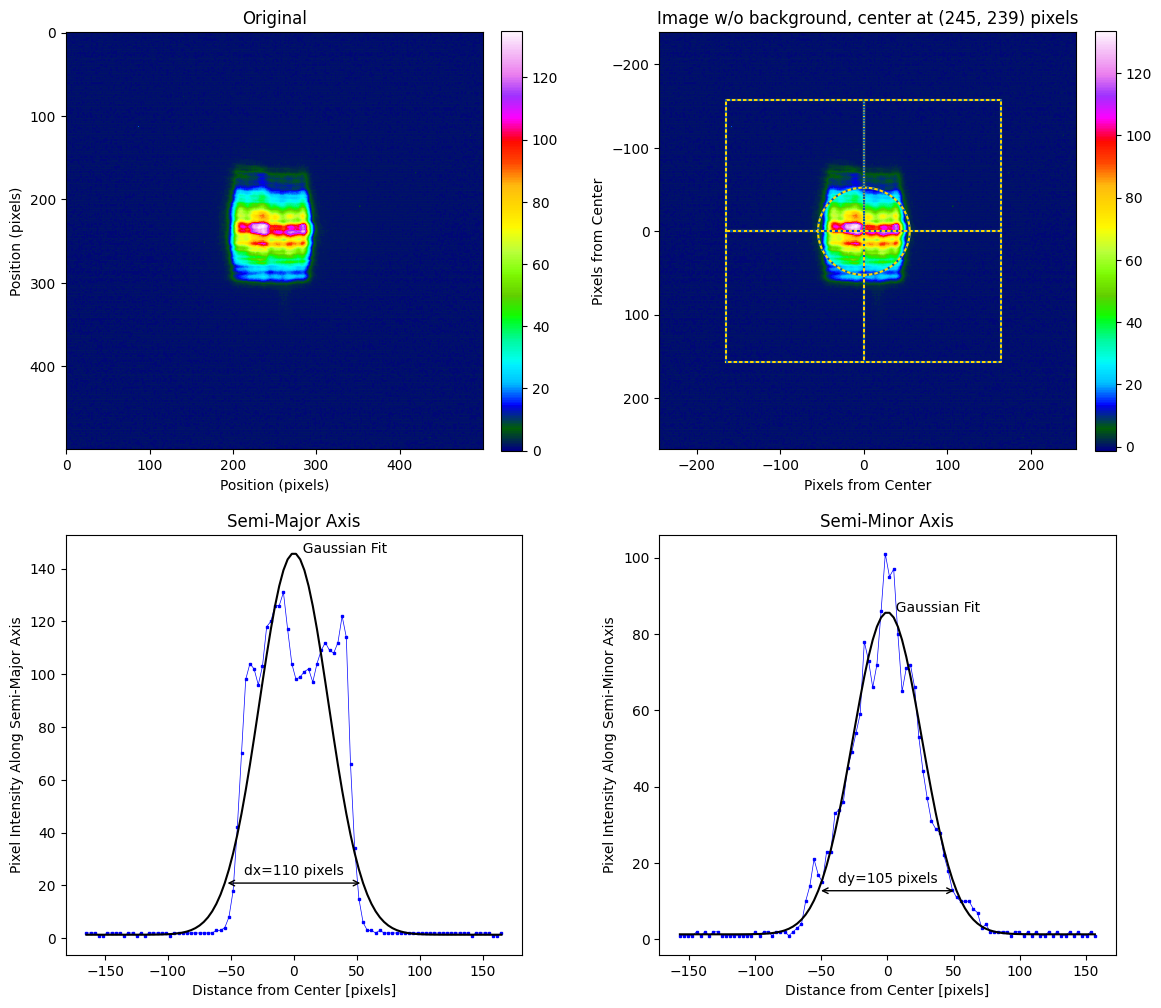

In [3]:
lbs.plot_image_analysis(beam,phi=np.radians(90))
plt.show()

In [4]:
xc, yc, dx, dy, phi = lbs.beam_size(beam,phi=np.radians(90))
print(dx,dy,np.degrees(phi))
xc, yc, dx, dy, phi = lbs.beam_size(beam)
print(dx,dy,np.degrees(phi))

104.55350527244406 109.87257341135276 90.0
104.7628011197191 109.57482690371936 33.58008174752168


### Analyzing a beam at multiple locations with fixed rotation

Here is a TEM01 beam that is rotated.  First we will look at an analysis using the defaults.  Then we will find the average rotation in all the images.  Finally, we will do an analysis using the average value.

Analysis of multiple images fail when `iso_noise=True`.  These are pretty noisy images.

In [5]:
lambda0 = 632.8e-9 # meters
z10 = np.array([247,251,259,266,281,292])*1e-3 # image location in meters
filenames = [repo + "sb_%.0fmm_10.pgm" % (number*1e3) for number in z10]

# the 12-bit pixel images are stored in high-order bits in 16-bit values
tem10 = [iio.imread(name)>>4 for name in filenames]

# remove top to eliminate artifact 
for i in range(len(z10)):
    tem10[i] = tem10[i][200:,:]

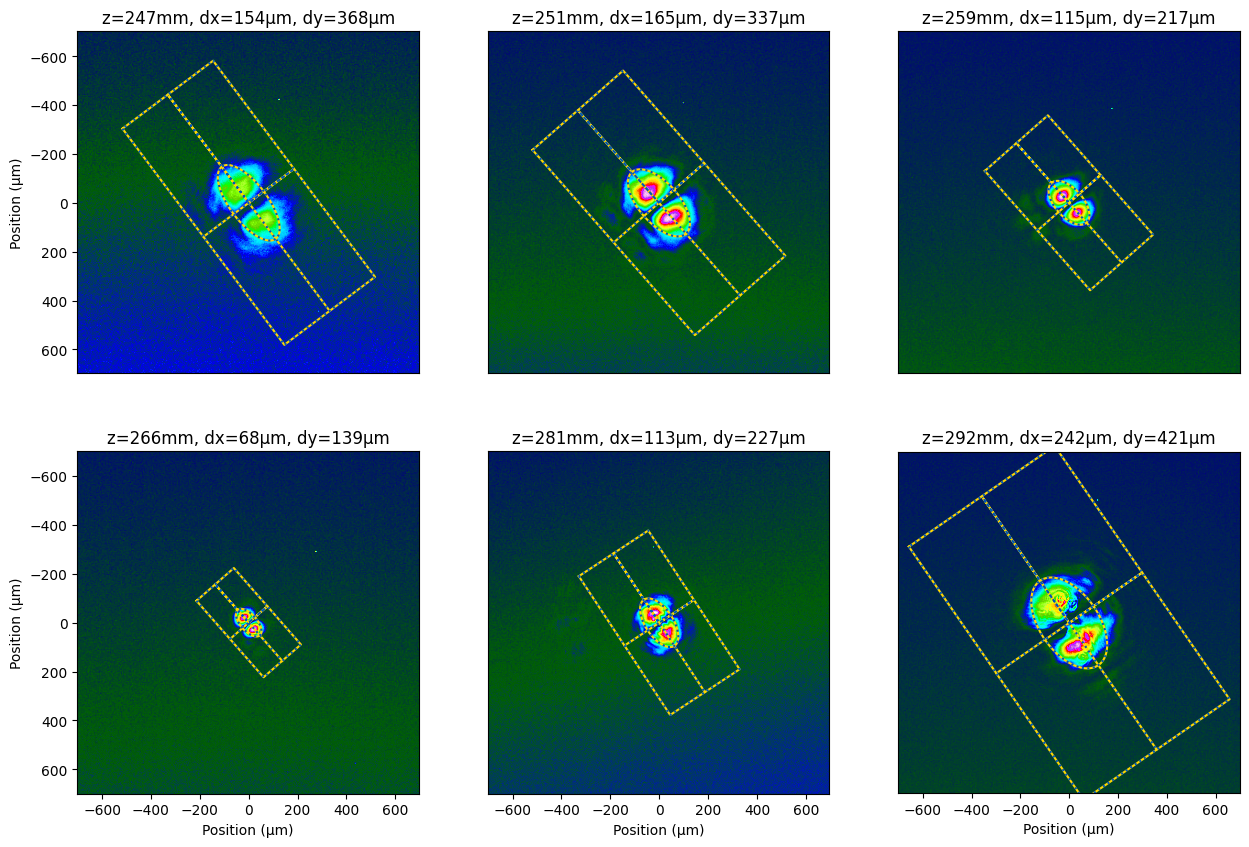

In [6]:
# find beam in all the images and create arrays of beam diameters
options = {'pixel_size': 3.75, 'units': "µm", 'crop': [1400,1400], 'z':z10, 'iso_noise':False}
dy, dx= lbs.plot_image_montage(tem10, **options)  # dy and dx in microns
plt.show()

In [7]:
# find the average rotation

allphi = np.array([])

for im in tem10:
    xc, yc, dx, dy, phi = lbs.beam_size(im)
    allphi = np.append(allphi,phi)
    
allphi = np.degrees(allphi)

print("%.1f±%.1f°" % (np.mean(allphi),np.std(allphi)))

8.4±15.1°


Now just use this average angle for all fast and slow axis calculations

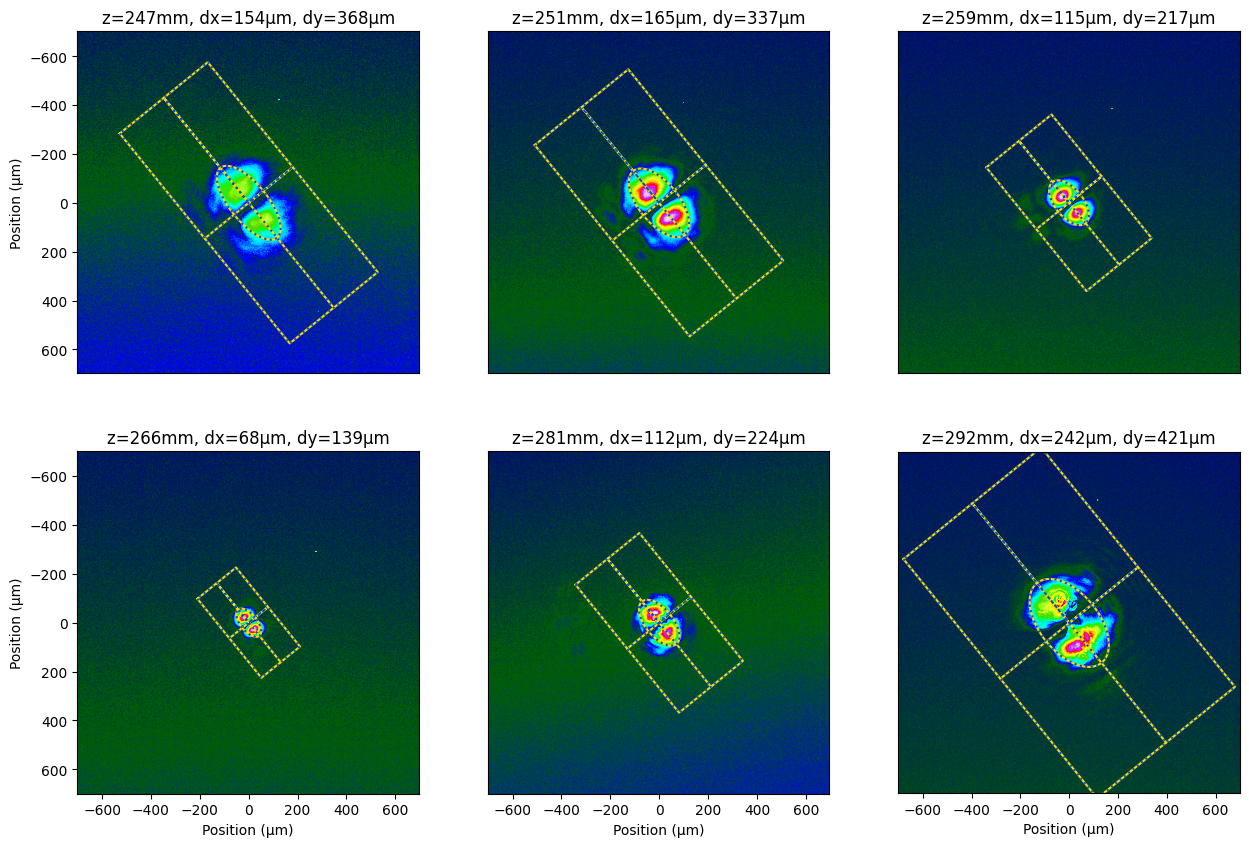

In [8]:
options = {'pixel_size': 3.75, 'units': "µm", 'crop': [1400,1400], 'z':z10, 'phi':np.radians(39), 'iso_noise':False}
dy, dx= lbs.plot_image_montage(tem10, **options)  # dy and dx in microns
plt.show()